In [1]:
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.policy.policy import Policy

#import gym
import gymnasium as gym

from gym.core import ActionWrapper
import glob

import shutil
import os 

import numpy as np

import json
import random
import ast
from scipy import interpolate
import math
from typing import Any, Dict, Union
import time
import pathlib
from functools import partial
import datetime
import pandas as pd

import sys
import matplotlib.pyplot as plt


from sim import cstr_model as cstr



In [36]:
class CSTREnv(gym.Env):
    def __init__(self, env_config):
        #n_vars = 5 #T,Tc,Ca,Cr,Tr
        #n_actions = 1 #dTc
        self.Cref_signal = env_config['Cref_signal']
        self.selector = env_config['selector']
        self.model = env_config['model']

        if self.selector == True:
            self.action_space = gym.spaces.Discrete(3) ##add number of concepts
            self.models = []

            for i in self.model:
                self.models.append(Policy.from_checkpoint(glob.glob(i+"/*")[-1])['default_policy'] )

            self.model = self.models

        else:
            self.action_space = gym.spaces.Box(low=np.array([-10.0]), high=np.array([10.0]))

        self.observation_space = gym.spaces.Box(low=np.array([200, 200, 0, 0, 200]), high=np.array([500, 500, 12, 12, 500]))   

    def reset(self):
        noise_percentage = 0
        Cref_signal = self.Cref_signal

        #initial conditions
        Ca0: float = 8.5698 #kmol/m3
        T0: float = 311.2639 #K
        Tc0: float = 292 #K

        self.T = T0
        self.Tc = Tc0
        self.Ca = Ca0
        self.ΔTc = 0

        self.cnt = 0

        self.Cref_signal = Cref_signal
        self.noise_percentage = noise_percentage
        if self.noise_percentage > 0:
            self.noise_percentage = self.noise_percentage/100

        if self.Cref_signal == 2:
            self.Cref = 2
            self.Tref = 373.1311
            self.Ca = 2
            self.T = 373.1311
        else:
            self.Cref = 8.5698
            self.Tref = 311.2612

        self.rms = 0
        self.y_list = []
        self.obs = np.array([self.T,self.Tc,self.Ca,self.Cref,self.Tref], dtype=np.float32)
        return self.obs

    def step(self, action):
        if self.Cref_signal == 0:
            self.Cref = 0
            self.Tref = 0
        elif self.Cref_signal == 1: #transition
            #update Cref an Tref
            time = 90
            p1 = 22 
            p2 = 74
            k = self.cnt+p1
            ceq = [8.57,6.9275,5.2850,3.6425,2]
            teq = [311.2612,327.9968,341.1084,354.7246,373.1311]
            C = interpolate.interp1d([0,p1,p2,time], [8.57,8.57,2,2])
            self.Cref = float(C(k))
            T_ = interpolate.interp1d([0,p1,p2,time], [311.2612,311.2612,373.1311,373.1311])
            self.Tref = float(T_(k))
        elif self.Cref_signal == 2: #steady state 1
            self.Cref = 2
            self.Tref = 373.1311
        elif self.Cref_signal == 3: #steady state 2
            self.Cref = 8.5698
            self.Tref = 311.2612
        elif self.Cref_signal == 4: #full sim
            k = self.cnt
            time = 90
            #update Cref an Tref
            p1 = 22 
            p2 = 74 
            ceq = [8.57,6.9275,5.2850,3.6425,2]
            teq = [311.2612,327.9968,341.1084,354.7246,373.1311]
            C = interpolate.interp1d([0,p1,p2,time], [8.57,8.57,2,2])
            self.Cref = float(C(k))
            T_ = interpolate.interp1d([0,p1,p2,time], [311.2612,311.2612,373.1311,373.1311])
            self.Tref = float(T_(k))

        if self.selector == True:
            self.ΔTc = self.model[action].compute_single_action(self.obs)[0][0]
        else:
            self.ΔTc = action

        error_var = self.noise_percentage
        σ_max1 = error_var * (8.5698 - 2)
        σ_max2 = error_var * ( 373.1311 - 311.2612)

        σ_Ca = random.uniform(-σ_max1, σ_max1)
        σ_T = random.uniform(-σ_max2, σ_max2)
        mu = 0

        #calling the CSTR python model
        sim_model = cstr.CSTRModel(T = self.T, Ca = self.Ca, Tc = self.Tc, ΔTc = self.ΔTc)

        #Tc
        self.Tc += self.ΔTc

        #Tr
        self.T = sim_model.T + σ_T

        #Ca
        self.Ca = sim_model.Ca + σ_Ca
        self.y_list.append(self.Ca)

        #Increase time
        self.cnt += 1

        self.rms = math.sqrt( (self.Ca - self.Cref)**2 )

        reward = float(1/self.rms)

        done = False

        #end the simulation
        if self.cnt == 90 or self.T >= 400 or (self.Cref_signal == 1 and self.cnt == 68): 
            done = True

        info = {}
        
        self.obs = np.array([self.T,self.Tc,self.Ca,self.Cref,self.Tref], dtype=np.float32)
        return self.obs, reward, done, info





In [5]:
def train_cstr_model(concept,selector = False, model = None):
    #ray.shutdown()
    #ray.init()
    path_root0 = "/models/"
    path_root = os.getcwd() + path_root0
    path = path_root + "cstr_rllib_model_" + concept
    print(path)

    if concept == 'ss1':
        cstr_config = 3
    elif concept == 'ss2':
        cstr_config = 2
    elif concept == 'transition':
        cstr_config = 1
    else:
        cstr_config = 4

    algo = ppo.PPOTrainer(env=CSTREnv, config={
      "env_config": {"Cref_signal":cstr_config,
                     "selector": selector,
                     "model": model},  # config to pass to env class
    })

        #algo = config.build(env=CSTREnv, config={"a": 0} )  
        #if selector == True:
        #  algo.restore(path)

    s = "{:3d} reward {:6.2f} < {:6.2f} < {:6.2f} len {:6.2f}"
    for n in range(20):
        result = algo.train()
        #print(result)

    print(s.format(
        n+1,
        result["episode_reward_min"],
        result["episode_reward_mean"],
        result["episode_reward_max"],
        result["episode_len_mean"]
        ))
    
    # Save state of the trained Algorithm in a checkpoint.
    #if selector == False:
    #os.mkdir(path_root)
    #shutil.rmtree(path, ignore_errors=True, onerror=None)
    checkpoint_dir = algo.save(path)

    #ray.shutdown()
  
    return path

In [6]:
ray.shutdown()
#ray.init(ignore_reinit_error=False)
ray.init()

2023-03-11 14:49:25,199	INFO worker.py:1550 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.7.4
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [46]:
#Train the transition model
trans_model = train_cstr_model('transition')

2023-03-11 15:16:03,628	WARNING deprecation.py:51 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.CSTREnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.CSTREnv'>').build()` instead. This will raise an error in the future!


G:\Projetos Python\DRL Bonsai\RLLib\cstr/models/cstr_rllib_model_transition


(RolloutWorker pid=5256) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=5256)   logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=5256) 2023-03-11 15:16:10,543	WARNING utils.py:166 -- `config.auto_wrap_old_gym_envs` is activated AND you seem to have provided an old gym-API environment. RLlib will therefore try to auto-fix the following error. However, please consider switching over to the new `gymnasium` APIs:
(RolloutWorker pid=5256) Your environment ({}) does not abide to the new gymnasium-style API!
(RolloutWorker pid=5256) From Ray 2.3 on, RLlib only supports the new (gym>=0.26 or gymnasium) Env APIs.
(RolloutWorker pid=5256) {}
(RolloutWorker pid=5256) Learn more about the most important changes here:
(RolloutWorker pid=5256) https://github.com/openai/gym and here: https://github.com/Farama-Foundatio

2023-03-11 15:16:12,421	WARNING util.py:67 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=5256) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\_private\workers\default_worker.py:134: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
(RolloutWorker pid=5256)   )
(RolloutWorker pid=3516) c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\_private\workers\default_worker.py:134: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
(RolloutWorker pid=

RayTaskError(ValueError): [36mray::RolloutWorker.apply()[39m (pid=5256, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x00000125F9530D08>)
  File "python\ray\_raylet.pyx", line 857, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 861, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 803, in ray._raylet.execute_task.function_executor
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\utils\actor_manager.py", line 183, in apply
    raise e
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\utils\actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 86, in <lambda>
    lambda w: w.sample(), local_worker=False, healthy_only=True
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\evaluation\rollout_worker.py", line 914, in sample
    batches = [self.input_reader.next()]
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\evaluation\sampler.py", line 92, in next
    batches = [self.get_data()]
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\evaluation\sampler.py", line 277, in get_data
    item = next(self._env_runner)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\evaluation\env_runner_v2.py", line 323, in run
    outputs = self.step()
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\evaluation\env_runner_v2.py", line 354, in step
    infos=infos,
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\evaluation\env_runner_v2.py", line 616, in _process_observations
    processed = policy.agent_connectors(acd_list)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\connectors\agent\pipeline.py", line 41, in __call__
    ret = c(ret)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\connectors\connector.py", line 254, in __call__
    return [self.transform(d) for d in acd_list]
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\connectors\connector.py", line 254, in <listcomp>
    return [self.transform(d) for d in acd_list]
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\connectors\agent\obs_preproc.py", line 59, in transform
    d[SampleBatch.NEXT_OBS]
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\models\preprocessors.py", line 206, in transform
    self.check_shape(observation)
  File "c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\ray\rllib\models\preprocessors.py", line 80, in check_shape
    self._obs_space,
ValueError: Observation ([272.2786   176.95445    9.906908   2.       373.1311  ] dtype=float32) outside given space (Box([200. 200.   0.   0. 200.], [500. 500.  12.  12. 500.], (5,), float32))!

In [ ]:
#ray.shutdown()
#ray.init()

#Train Steady State 2 model
ss2_model = train_cstr_model('ss2')

In [ ]:
#ray.shutdown()
#ray.init()

#Train Steady State 1 model
ss1_model = train_cstr_model('ss1')

In [ ]:
#ray.shutdown()
#ray.init()

#Train Selector
#selectorx = train_cstr_model('full',True,["/tmp/rllib_model_ss1", "/tmp/rllib_model_ss2"])
selectorx = train_cstr_model('full',True,[trans_model, ss1_model, ss2_model])

In [47]:
glob.glob(selectorx+"/*")

['G:\\Projetos Python\\DRL Bonsai\\RLLib\\cstr/models/cstr_rllib_model_full\\checkpoint_000005',
 'G:\\Projetos Python\\DRL Bonsai\\RLLib\\cstr/models/cstr_rllib_model_full\\checkpoint_000020']

In [48]:
#Benchmark

bench_env = CSTREnv({"Cref_signal":4,"selector": True, "model":[trans_model, ss1_model, ss2_model]})

c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\gymnasium\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [49]:
obs = bench_env.reset()

In [50]:
model = Algorithm.from_checkpoint(glob.glob(selectorx+"/*")[-1])
#model = Algorithm.from_checkpoint('G:\\Projetos Python\\DRL Bonsai\\RLLib\\cstr\\models\\cstr_rllib_model_full\\checkpoint_000005')

(RolloutWorker pid=20280) WARNING: Logging before flag parsing goes to stderr.
(RolloutWorker pid=20280) W0311 15:16:44.027879 19192 deprecation.py:506] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
(RolloutWorker pid=20280) Instructions for updating:
(RolloutWorker pid=20280) If using Keras pass *_constraint arguments to layers.
(RolloutWorker pid=4792) WARNING: Logging before flag parsing goes to stderr.
(RolloutWorker pid=4792) W0311 15:16:44.027879  8120 deprecation.py:506] From c:\users\octavio\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will b

In [51]:
df = pd.DataFrame()

In [52]:
for n in range(90):
    action = model.compute_single_action(obs)
    obs, reward, done, info = bench_env.step(action)
    df = df.append( pd.DataFrame(columns=['T', 'Tc','Ca','Cref','Tref'], data=[obs]))
    #print(reward)
    #print(action,obs[0])

0 310.4287
0 309.8238
0 309.45242
0 309.25958
0 309.03387
0 309.07047
0 309.20197
0 309.30484
0 309.42102
1 309.64682
2 309.84235
1 309.9478
0 310.07452
1 310.23102
0 310.39423
0 310.60052
1 310.882
0 311.00308
0 311.1901
0 311.31604
0 311.41882
0 311.38727
2 311.4236
0 311.51797
0 311.73334
0 312.0533
0 312.43793
1 312.8366
1 313.156
1 313.45654
1 313.72482
0 313.92105
0 314.0943
0 314.1251
2 314.14188
1 314.13303
1 314.07675
1 314.04007
0 313.9618
1 314.1211
0 314.26385
1 314.46246
0 314.62427
0 314.8163
0 315.12943
2 315.49472
0 315.75525
0 316.01642
0 316.38226
0 317.01328
0 317.6563
0 318.42477
0 319.33295
0 320.16226
1 320.88785
0 321.71643
0 322.56406
1 323.43686
1 324.47064
0 325.4809
0 326.60577
0 327.9589
1 329.6384
0 331.59995
0 334.13486
1 337.44305
0 342.17523
0 349.92593
0 363.69153
0 382.307
0 386.03894
0 383.50714
0 381.8017
1 381.33786
1 381.17264
2 381.1906
0 381.2591
2 381.28754
0 381.2948
0 381.39246
0 381.6302
0 381.99765
0 382.55405
0 383.09613
0 383.4085
1 383.22

In [53]:
df = df.reset_index()

<AxesSubplot:>

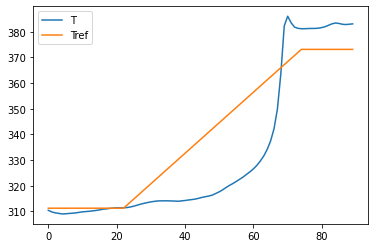

In [54]:
df[['T','Tref']].plot()

<AxesSubplot:>

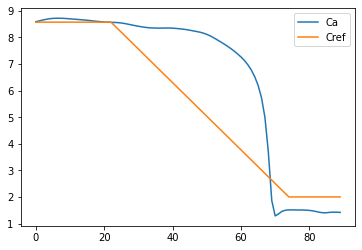

In [55]:
df[['Ca','Cref']].plot()

<AxesSubplot:>

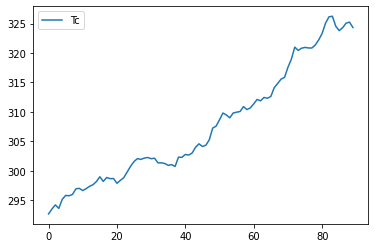

In [56]:
df[['Tc']].plot()

In [ ]:
ppo2['default_policy'].compute_single_action(np.array([4.5607401e+02, 4.7123825e+02, 3.0847624e-01, 7.6466050e+00,
       3.6512253e+02], dtype='float32'))[0][0]

In [24]:
print(os.getcwd())

G:\Projetos Python\DRL Bonsai\RLLib\cstr


In [23]:

print(os.chdir("G:\Projetos Python\DRL Bonsai\RLLib\cstr"))

G:\tmp
None


In [16]:
os.mkdir("/tmp/")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/tmp/'